In [16]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

#import torch_xla
#import torch_xla.core.xla_model as xm

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer
stop_words = get_stop_words('en')
stop_words.append(' ')
stop_words.append('')

In [2]:
random.seed(2020)
np.random.seed(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X


In [64]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
for i in range(4):    
    train_df = pd.merge(train_df, pd.read_csv(f'../train_df_off{i+1}.csv'), on='id')
    test_df = pd.merge(test_df, pd.read_csv(f'../test_df_off{i+1}.csv').drop(columns=['description', 'jobflag']), on='id')
df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
df['text_id'] = df['id']
del df['id']
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

cols = ['jobflag','text_id']
X = preprocessing.vectorize_tfidf(df)
X = pd.concat([df[cols], X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

feature = train_df.drop(columns=cols).columns.tolist()

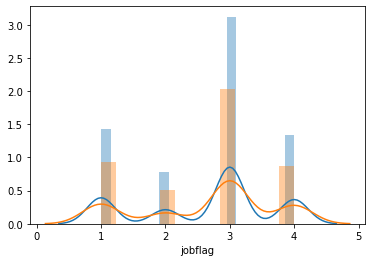

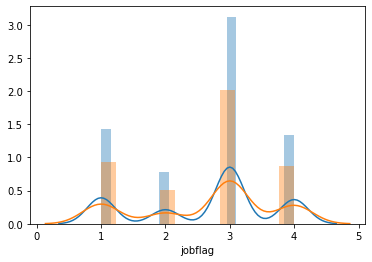

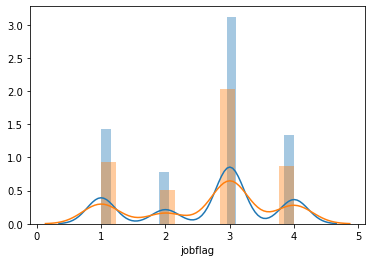

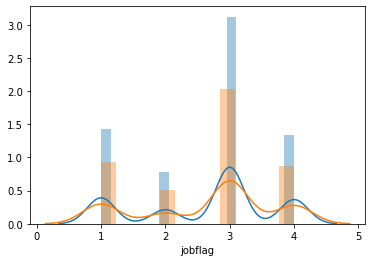

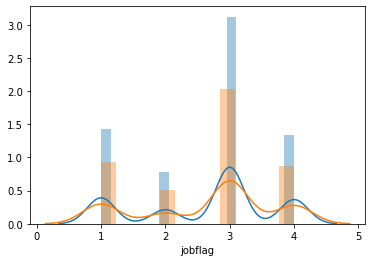

In [69]:
off_df_mlp, trn_cv_loss, val_cv_loss = make_off_df(train_df, feature)

In [70]:
off_df_mlp.head()

,jobflag,text_id,000,10,10g,11,12,12c,150,20,...,p_1_38,p_2_38,p_3_38,p_4_38,p_38,p_1_39,p_2_39,p_3_39,p_4_39,p_39
0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011995,0.045376,0.881270,0.061359,3,0.010006,0.040143,0.895238,0.054613,3
1,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009087,0.012833,0.673399,0.304680,3,0.008324,0.011208,0.665379,0.315089,3
2,4.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027004,0.009939,0.147188,0.815868,4,0.021528,0.008070,0.134413,0.835989,4
3,1.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.120829,0.031168,0.180682,0.667321,4,0.101961,0.025275,0.163729,0.709035,4
4,4.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038560,0.011309,0.344802,0.605328,4,0.035533,0.009406,0.319972,0.635089,4


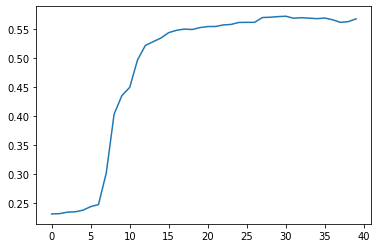

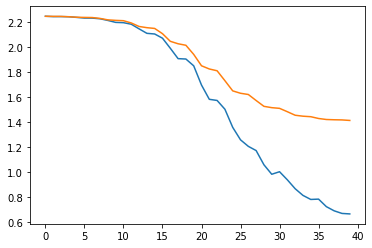

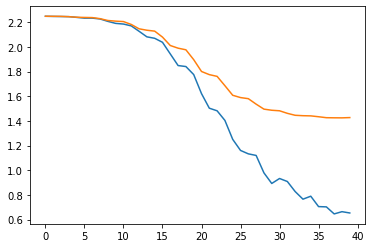

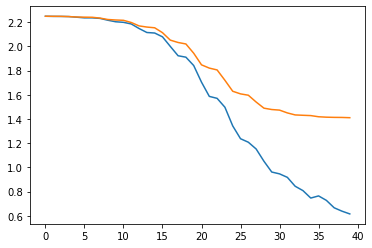

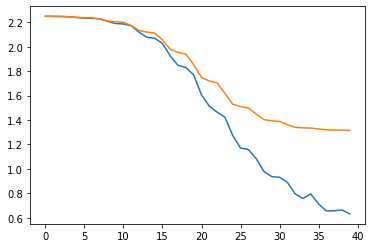

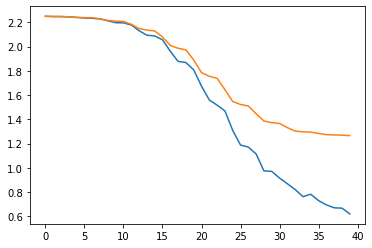

,score
28,0.570008
29,0.571108
30,0.571728


In [71]:
scores=[]
for i in range(40):   
    p = off_df[f'p_{i}']
    label = off_df['jobflag']
    score = metrics.f1_score(label, p, average='macro')
    scores.append(score)
plt.plot(scores)
plt.show()

for i in range(len(trn_cv_loss)):
    plt.plot(trn_cv_loss[i])
    
    plt.plot(val_cv_loss[i])
    plt.show()

data = pd.DataFrame()
data['score'] = scores
data[data.score>0.57]

In [ ]:
test_df, trn_loss_list = predict_test_df(train_df, test_df, feature)

In [ ]:
test_df.head()

In [ ]:
plt.plot(trn_loss_list)

In [ ]:
test_df[]

In [ ]:
preds = np.zeros((len(test_df), 4))
for i in range(28, 32):
    preds += test_df[[f'p_{label+1}_{i}'  for label in range(4)]].values/7

In [ ]:
preds

In [ ]:
test_df['final_preds'] = 1+np.argmax(preds, axis=1)

In [ ]:
#test_df[['text_id', 'final_preds']].to_csv('/Users/abcdm/Downloads/sub_15.csv', index=False, header=False)

In [ ]:
data = pd.merge(
    pd.read_csv('/Users/abcdm/Downloads/sub_15.csv', header=None),
    pd.read_csv('/Users/abcdm/Downloads/sub_14.csv', header=None),
    on=[0]
)

pd.concat([
    pd.get_dummies(data['1_x']).rename(
        columns={i:f'{i}_15' for i in range(4)}
    ),
    pd.get_dummies(data['1_y']).rename(
        columns={i:f'{i}_14' for i in range(4)}
    )
], axis=1).corr()